In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import os
from torchvision import datasets, transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xray_dataset import XRayDataset
from transforms import equalize

# Set up the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Import Data

In [8]:
# make sure data is in root directory
data_dir = '/Users/ruchireddy/nih-chest-xray-dataset/'
bad_labels = pd.read_csv(data_dir + 'cxr14_bad_labels.csv')
bad_labels = bad_labels.loc[:, ~bad_labels.columns.str.contains('^Unnamed')]
all_df = pd.read_csv(data_dir + 'train_df.csv')
all_df = all_df.drop(columns=['Patient ID'])
all_df = all_df.dropna()

LABELS = all_df.columns.tolist()[1:-1]
print("Labels:", LABELS)
print()

print('bad_labels:')
display(bad_labels.head())
print()

print('all_df:')
display(all_df.head())

img_dict = {}
for root, _, files in os.walk(data_dir):
    for file_name in files:
        if file_name.endswith(".png"):
            full_path = os.path.join(root, file_name)
            img_dict[file_name] = [full_path]

for index, row in all_df.iterrows():
    img_dict[row[0]].append(np.array(row[1:-1], dtype=int))

# List all files in the data directory
print(f'Total image files found : {len(img_dict.keys())}')

Labels: ['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

bad_labels:


,Index,Inverted,Not frontal,Rotated
0,00000583_024.png,1.0,0.0,0.0
1,00002180_000.png,1.0,0.0,0.0
2,00002300_026.png,1.0,0.0,0.0
3,00002371_015.png,1.0,0.0,0.0
4,00006209_001.png,1.0,0.0,0.0



all_df:


,Image Index,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


/var/folders/m6/n94d18910t93n63044f2y9cm0000gn/T/ipykernel_13934/4196785590.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_dict[row[0]].append(np.array(row[1:-1], dtype=int))


Total image files found : 112120


In [9]:
print('img_dict length before dropping bad labels: ', len(img_dict.keys()))
print('total number of bad_labels: ', bad_labels.shape)

# Remove images from img_dict that exist in bad_labels
for bad_image in bad_labels['Index']:
    if bad_image in img_dict:
        del img_dict[bad_image]

print('img_dict length after dropping bad labels: ', len(img_dict.keys()))

img_dict length before dropping bad labels:  112120
total number of bad_labels:  (432, 4)
img_dict length after dropping bad labels:  111863


In [42]:
img_dict['00000001_000.png']

['/Users/ruchireddy/nih-chest-xray-dataset/images_001/images/00000001_000.png',
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [10]:
# Split the data into 80% train and 20% test
train_img_paths_and_labels, test_img_paths_and_labels = train_test_split(list(img_dict.values()), test_size=0.3, random_state=42)

# split into validation and test
test_img_paths_and_labels, val_img_paths_and_labels = train_test_split(test_img_paths_and_labels, test_size=0.5, random_state=42)

#  Define a transformation to convert images to tensors
train_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),    # horizontal flip could not be consistent with the labels for xray images
    # transforms.RandomRotation(10),    rotations not advised for x-ray images
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Lambda(equalize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset class for the XRay images
train_dataset = XRayDataset(train_img_paths_and_labels, transform=train_transform)
val_dataset = XRayDataset(val_img_paths_and_labels, transform=test_transform)
test_dataset = XRayDataset(test_img_paths_and_labels, transform=test_transform)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [44]:
# check if the data is loaded correctly
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape, len(labels))

torch.Size([64, 3, 224, 224]) 64


tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])


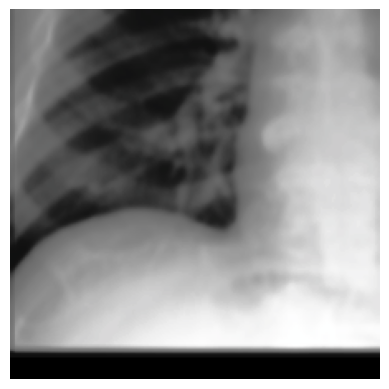

In [45]:
# print a sample image
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Display the image
imshow(images[0], normalize=True)
print(labels[0])

In [46]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.float()
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        p_t = torch.where(targets == 1, probs, 1 - probs)
        focal_factor = (1 - p_t) ** self.gamma
        loss = self.alpha * focal_factor * BCE_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [11]:
# class for the model
class XRayModel(nn.Module):
    def __init__(self, num_classes):
        super(XRayModel, self).__init__()
        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        num_feats = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_feats, 1024),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
       
    def forward(self, x):
        x = self.densenet(x)
        return x

In [48]:
# Define the model, optimizer, and loss function
model = XRayModel(num_classes=len(LABELS))
model.to(device)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = FocalLoss()
num_epochs = 1


In [15]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        print(f'Batch [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        i += 1
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    i = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            print(f'Validation Batch [{i+1}/{len(val_loader)}], Loss: {loss.item()}')
            i += 1

    print(f'Validation Loss: {val_running_loss/len(val_loader)}')

# save the model
torch.save(model.state_dict(), 'xray_model.pth')

Batch [1/1224], Loss: 0.042823053896427155
Batch [2/1224], Loss: 0.01900273747742176
Batch [3/1224], Loss: 0.01956784911453724
Batch [4/1224], Loss: 0.01598248817026615
Batch [5/1224], Loss: 0.018522094935178757
Batch [6/1224], Loss: 0.02133447863161564
Batch [7/1224], Loss: 0.015782754868268967
Batch [8/1224], Loss: 0.01672561652958393
Batch [9/1224], Loss: 0.015340062789618969
Batch [10/1224], Loss: 0.016412919387221336
Batch [11/1224], Loss: 0.016173377633094788
Batch [12/1224], Loss: 0.018537888303399086
Batch [13/1224], Loss: 0.015148982405662537
Batch [14/1224], Loss: 0.01635126583278179
Batch [15/1224], Loss: 0.015832792967557907
Batch [16/1224], Loss: 0.01570129580795765
Batch [17/1224], Loss: 0.015568257309496403
Batch [18/1224], Loss: 0.010142013430595398
Batch [19/1224], Loss: 0.017368368804454803
Batch [20/1224], Loss: 0.014346049167215824
Batch [21/1224], Loss: 0.014766816049814224
Batch [22/1224], Loss: 0.01599353551864624
Batch [23/1224], Loss: 0.012190328910946846
Batch

In [49]:
from sklearn.metrics import classification_report

# Load the model
model.load_state_dict(torch.load('xray_model.pth', map_location=device))

# Validation loop
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Calculate classification report
report = classification_report(all_labels, all_predictions, target_names=LABELS, output_dict=True)
print("Classification Report:")
print(report)

# Print F1 scores, precision, and recall for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg']:
        print(f"Class: {class_name}")
        print(f"  Precision: {metrics['precision']}")
        print(f"  Recall: {metrics['recall']}")
        print(f"  F1 Score: {metrics['f1-score']}")

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ruchireddy/ne_ds4440/.conda/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ruchireddy/ne_ds4440/.conda/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ruchireddy/ne_ds4440/.conda/lib/python3.12/site-packages/torch/__init__.py", line 1477, in <module>
    from .functional import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ruchireddy/ne_ds4440/.conda/lib/python3.12/site-packages/torch/functional.py", line 9, in <module>
    import torch.nn.functional as F
  File "/Users/ruchireddy/ne_ds4440/.conda/lib/python3.12/site-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/

KeyboardInterrupt: 

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def create_tensorboard_visualization(model_path, data_loader, device):
    # Load the model
    model = XRayModel(num_classes=len(LABELS))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Create a SummaryWriter
    writer = SummaryWriter(log_dir='logs/tensorboard')

    # Extract embeddings and labels
    embeddings = []
    labels_list = []
    with torch.no_grad():
        i = 0
        for images, labels in data_loader:
            print('iter:', i)
            images = images.to(device)
            labels = labels.to(device)
            
            # Get the embeddings from the layer before the output layer
            features = model.densenet.features(images)
            embeddings.append(features.cpu())
            labels_list.append(labels.cpu())
            i += 1

    # Concatenate all embeddings and labels
    embeddings = torch.cat(embeddings, dim=0)
    labels_list = torch.cat(labels_list, dim=0)

    # Add embeddings to TensorBoard
    writer.add_embedding(embeddings, metadata=labels_list, label_img=images.cpu())

    # Close the writer
    writer.close()

# Example usage
# Assuming you have a DataLoader named test_loader
# create_tensorboard_visualization("xray_model.pth", test_loader, device)


In [3]:
!tensorboard --logdir=logs/tensorboard

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


In [13]:
device = torch.device("cpu")  # ✅ Ensure `device` is correctly formatted

create_tensorboard_visualization("xray_model.pth", test_loader, device)

AttributeError: 'collections.OrderedDict' object has no attribute 'to'